# Quantile Predictions

In this example we'll use power output data from Portugese hydro-plants to demonstrate how the quantile LOWESS model can be used.

<br>

### Imports

In [7]:
import pandas as pd

import matplotlib.pyplot as plt

from moepy import lowess, eda

<br>

### Loading Data

We'll start by reading in the Portugese hydro output data

In [2]:
df_portugal_hydro = pd.read_csv('../data/lowess_examples/portugese_hydro.csv')

df_portugal_hydro.index = pd.to_datetime(df_portugal_hydro['datetime'])
df_portugal_hydro = df_portugal_hydro.drop(columns='datetime')

df_portugal_hydro['day_of_the_year'] = df_portugal_hydro.index.dayofyear
df_portugal_hydro = df_portugal_hydro.resample('D').mean()
df_portugal_hydro = df_portugal_hydro.rename(columns={'power_MW': 'average_power_MW'})

df_portugal_hydro.head()

,average_power_MW,day_of_the_year
datetime,,
2015-01-01,698.500000,1
2015-01-02,1065.750000,2
2015-01-03,905.125000,3
2015-01-04,795.708333,4
2015-01-05,1141.625000,5


<br>

### Quantile LOWESS

We now just need to feed this data into our `quantile_model` wrapper

In [4]:
# Estimating the quantiles
df_quantiles = lowess.quantile_model(df_portugal_hydro['day_of_the_year'].values,
                                     df_portugal_hydro['average_power_MW'].values,
                                     frac=0.4, num_fits=40)

# Cleaning names and sorting for plotting
df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
df_quantiles = df_quantiles[df_quantiles.columns[::-1]]

df_quantiles.head()

 [████████████████████████████████████████████████████████████] 9/9 [00:16<00:02, 1.73s/it]

,p90,p80,p70,p60,p50,p40,p30,p20,p10
x,,,,,,,,,
1,1885.079172,1400.781601,1006.972631,910.768786,795.474566,693.000758,604.221026,498.095705,407.170002
2,1885.932585,1406.291952,1015.762933,917.073552,800.254803,697.120909,607.520973,500.673220,409.021489
3,1886.799899,1411.805229,1024.541485,923.369568,805.008381,701.225043,610.814367,503.239239,410.866080
4,1887.680853,1417.321378,1033.310416,929.659353,809.738103,705.316516,614.104565,505.797108,412.694541
5,1888.568977,1422.837956,1042.075556,935.951679,814.455951,709.409014,617.404051,508.358906,414.485478


<br>

We can then visualise the estimated quantile fits of the data

(0.0, 2620.8375)

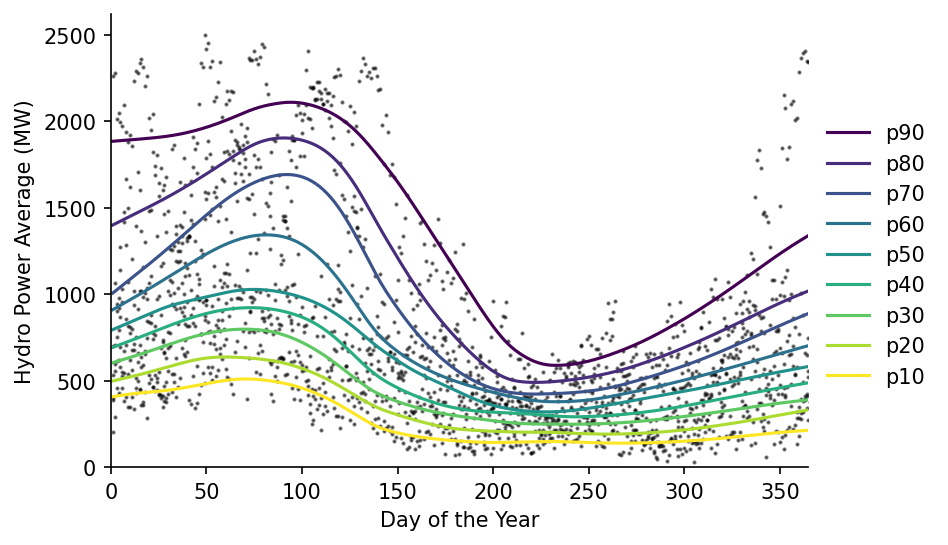

In [8]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(df_portugal_hydro['day_of_the_year'], df_portugal_hydro['average_power_MW'], s=1, color='k', alpha=0.5)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

eda.hide_spines(ax)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Hydro Power Average (MW)')
ax.set_xlim(0, 365)
ax.set_ylim(0)

<br>

We can also ask questions like: "what day of a standard year would the lowest power output be recorded?"

In [9]:
scenario = 'p50'

print(f'In a {scenario} year the lowest hydro power output will most likely fall on day {df_quantiles[scenario].idxmin()}')

In a p50 year the lowest hydro power output will most likely fall on day 228


<br>

We can also identify the peridos when our predictions will have the greatest uncertainty

Day 115 is most likely to have the greatest variation in hydro power output


(0.0, 1724.0724938300584)

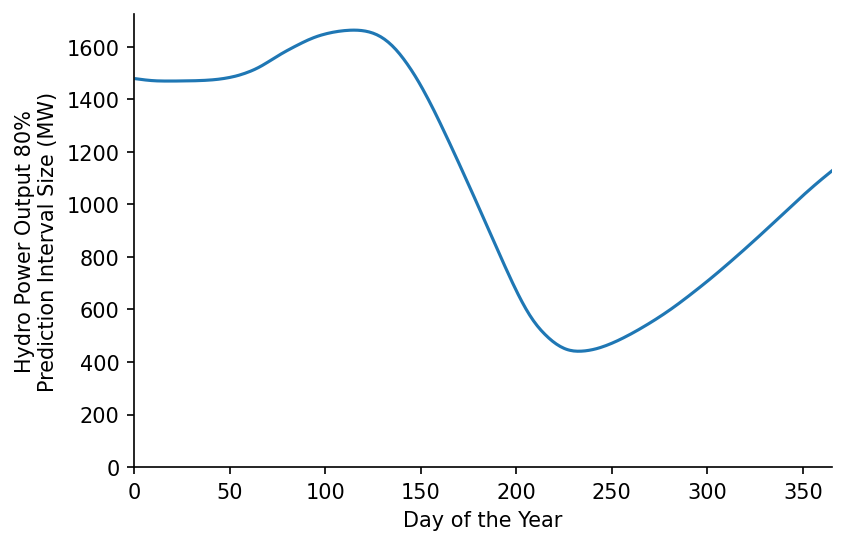

In [19]:
s_80pct_pred_intvl = df_quantiles['p90'] - df_quantiles['p10']

print(f'Day {s_80pct_pred_intvl.idxmax()} is most likely to have the greatest variation in hydro power output')

# Plotting
fig, ax = plt.subplots(dpi=150)

s_80pct_pred_intvl.plot(ax=ax)

eda.hide_spines(ax)
ax.set_xlabel('Day of the Year')
ax.set_ylabel('Hydro Power Output 80%\nPrediction Interval Size (MW)')
ax.set_xlim(0, 365)
ax.set_ylim(0)